# 新闻视频处理演示

在这个笔记本中，我们将要针对一则来自江西湖口的本地新闻进行如下的处理：

1. 按照 `cut-scene` 来切割出若干镜头

1. 对上一步切割出来的镜头进行分类，识别出:

  - 演播室（没有字幕）
  - 演播室（带有字幕）
  - 其它

1. 识别带有字幕的演播室镜头中的字幕文本

1. 识别演播室镜头中，播音员播报的语音内容，将它转为文本

## 准备工作

### 载入环境变量

这个笔记本的代码需要某些预定义的环境变量，所以 **必须** 加载:

In [1]:
%load_ext dotenv

%dotenv -o ../.env

### 验证 PyTorch 和 Matplotlib

我们还需要：

1. 验证 PyTorch 的情况：使用 CPU 还是 GPU

1. 设置 matplotlib 中文字体：是否可以在绘图中显示中文

   请根据实际情况设置有效的字体！

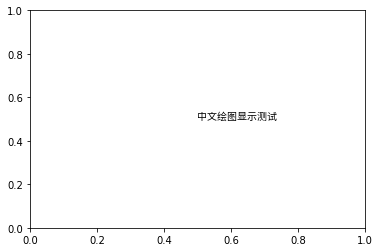

,Pytorch Version,Pytorch Device
0,1.0.1,cpu


In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import torch

mfm_font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
mfm_font_prop = mfm.FontProperties(fname=mfm_font_path)
plt.text(.5, .5, s='中文绘图显示测试', fontproperties=mfm_font_prop)
plt.pause(0.01)
plt.show()
plt.pause(0.01)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:

pd.DataFrame([{
    'Pytorch Version': torch.__version__,
    'Pytorch Device': device
}])

### 定义全局函数

定义几个用于 A/V 处理的全局函数

In [3]:
import os
import math
import base64
import hashlib
import json
import urllib
import subprocess
from copy import copy, deepcopy
from datetime import timedelta
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

import skimage
import torch
import requests

from tqdm import tqdm

from IPython.display import display, Image, Audio, Video


def run_ffmpeg(args=None, quiet=True, check=True, cmd=None):
    if not cmd:
        cmd = 'ffmpeg'
    args = args or []
    if quiet:
        kv_args = dict(stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    else:
        kv_args = dict()
    subprocess.run([cmd, '-y'] + args, check=check, **kv_args)

def trunc_av(video_file_path, start_seconds, end_seconds, output_path):
    start_time = timedelta(seconds=start_seconds)
    duration = timedelta(seconds=(end_seconds - start_seconds))
    args = [
        '-ss', str(start_time),
        '-i', str(video_file_path),
        '-t', str(duration),
        '-c', 'copy',
        # output:
        str(output_path)
    ]
    run_ffmpeg(args=args, quiet=False)

def trunc_a(video_file_path, start_seconds, end_seconds, output_path):
    output_file, _ = os.path.splitext(output_path)
    output_path = output_file + '.mp3'
    start_time = timedelta(seconds=start_seconds)
    duration = timedelta(seconds=(end_seconds - start_seconds))
    args = [
        '-ss', str(start_time),
        '-i', str(video_file_path),
        '-t', str(duration),
        '-vn', '-acodec', 'libmp3lame', '-b:a', '16k',
        # output:
        str(output_path)
    ]
    run_ffmpeg(args=args)


## 上传要处理的视频文件

上传一个湖口的新闻视频，并指定其路径。

本例中，我们上传文件 *湖口* *2019年05月16日* 的新闻录像到:

```sh
../videos/湖口/20190516.mp4
```

> **提示：**
>
> 笔记本 Web 界面左侧的文件浏览器支持拖拽

将文件路径复制到全局变量。后面的步骤需要使用该变量进行计算：

In [4]:
import os

VIDEO_DIR = '../videos'

# 定义要处理的视频文件路径之全局变量
VIDEO_FILE = os.path.join(
    VIDEO_DIR,
    "../videos/湖口/20190516.mp4"  # 在这里填写新实际要进行处理的视频文件！
)

print('要处理的文件：', os.path.abspath(VIDEO_FILE))  # 输出文件绝对路径
assert os.path.exists(VIDEO_FILE)  # 断言：文件存在

要处理的文件： /mnt/1B9074BA60C16502/works/huamei/jxcn-newsvideo/repositories/jxcn-newvideo-poc/videos/湖口/20190516.mp4


在下面的步骤中，我们将针对这个视频文件进行处理。

## 场景边界预测

这一小节中，我们需要根据视觉表征进行场景边界预测

在此之前，我们已经预先准备了一个使用根据图像表征进行视频场景边界检测的预训练模型。
这个模型可以预测出视频场景边界。

我们使用这个模型，对上传的新闻视频文件进行预测，得到它的场景边界。

In [5]:
print('进行场景边界检测...')
sleep(1)


from contextlib import contextmanager

from scenedetect.video_manager import VideoManager
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import SceneManager
from scenedetect.stats_manager import StatsManager

@contextmanager
def managed_video_manager(*args, **kwargs):
    video_manager = VideoManager(*args, **kwargs)
    try:
        yield video_manager
    finally:
        video_manager.release()

def cut_scenes(video_file_path):
    # cut-scenes 检测
    stats_manager = StatsManager()
    scene_manager = SceneManager(stats_manager)
    scene_manager.add_detector(ContentDetector())
    
    with managed_video_manager([str(video_file_path)]) as video_manager:
        # detect scenes
        video_manager.start()
        base_time_code = video_manager.get_base_timecode()
        num_frames = scene_manager.detect_scenes(frame_source=video_manager)
        if not num_frames > 0:
            raise RuntimeError('No scenes detected')
        scene_list = scene_manager.get_scene_list(base_time_code)
    # Ok.
    # 拼凑结果数据
    scenes = []
    for index, (start_time_code, end_time_code) in enumerate(scene_list):
        scenes.append({
            'index': index,
            'start_time': start_time_code.get_seconds(),
            'end_time': end_time_code.get_seconds(),
            'start_frame': start_time_code.get_frames(),
            'end_frame': end_time_code.get_frames(),
        })
    return scenes

scenes = cut_scenes(VIDEO_FILE)



##########################################

print('生成场景缩略图...')
sleep(1)


# 生成缩略图：

from shutil import rmtree
from datetime import timedelta
from string import Template
    
def take_images_in_timespan(
        video_file_path,
        start_time,
        end_time,
        output_file_name_format='$index.jpg',
        num=3
):
    output_tpl = Template(output_file_name_format)
    time_points = []
    img_file_list = []
    if num == 1:
        time_points.append(
            start_time + (end_time - start_time) / 2
        )
    else:
        span = (end_time - start_time) / (num - 1)
        time_points.append(start_time)
        for i in range(num - 2):
            time_points.append(
                start_time + span * (i + 1)
            )
        time_points.append(end_time)
    #
    for i, ss in enumerate(time_points):
        ss = timedelta(seconds=ss)
        output_path = output_tpl.substitute(index=i + 1)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        run_ffmpeg([
            '-ss', str(ss), '-i', video_file_path, '-vframes', '1', output_path
        ])
        img_file_list.append(output_path)
    return img_file_list


def take_scenes_images(video_file_path, scenes, output_dir):
    # 输出目录
    os.makedirs(output_dir, exist_ok=True)
    # 生成缩略图文件
    for i, scene in tqdm(enumerate(scenes), total=len(scenes)):
        start_time = scene['start_time']
        end_time = scene['end_time']
        snapshots = take_images_in_timespan(
            video_file_path, start_time, end_time,
            os.path.join(output_dir, '{}_$index.jpg'.format(i + 1)),
            1
        )
        scene['snapshots'] = snapshots


dirname, basename = os.path.split(VIDEO_FILE)
basename = os.path.splitext(basename)[0]
images_dir = os.path.join(
    '..',
    'tmp',
    'images',
    os.path.relpath(dirname, VIDEO_DIR),
    basename
)
rmtree(images_dir, ignore_errors=True)

print(f'tmp-dir: {images_dir}')
sleep(1)

%time take_scenes_images(VIDEO_FILE, scenes, images_dir)


进行场景边界检测...


100%|██████████| 18477/18477 [02:28<00:00, 128.34frames/s]


生成场景缩略图...
tmp-dir: ../tmp/images/湖口/20190516


100%|██████████| 140/140 [00:05<00:00, 26.25it/s]

CPU times: user 185 ms, sys: 601 ms, total: 786 ms
Wall time: 5.97 s


待上一步骤执行完毕后，我们打印检测到的场景列表（包含：顺序编号、起止时间、起止帧）：

In [6]:
pd.DataFrame(scenes)

,index,start_time,end_time,start_frame,end_frame,snapshots
0,0,0.00,5.00,0,125,[../tmp/images/湖口/20190516/1_1.jpg]
1,1,5.00,9.24,125,231,[../tmp/images/湖口/20190516/2_1.jpg]
2,2,9.24,16.44,231,411,[../tmp/images/湖口/20190516/3_1.jpg]
3,3,16.44,17.48,411,437,[../tmp/images/湖口/20190516/4_1.jpg]
4,4,17.48,18.96,437,474,[../tmp/images/湖口/20190516/5_1.jpg]
5,5,18.96,36.92,474,923,[../tmp/images/湖口/20190516/6_1.jpg]
6,6,36.92,38.04,923,951,[../tmp/images/湖口/20190516/7_1.jpg]
7,7,38.04,39.28,951,982,[../tmp/images/湖口/20190516/8_1.jpg]
8,8,39.28,40.16,982,1004,[../tmp/images/湖口/20190516/9_1.jpg]
9,9,40.16,40.96,1004,1024,[../tmp/images/湖口/20190516/10_1.jpg]


## 场景分类

我们已经制作了一个小的，可进行对场景进行图像分类的预训练模型，它可以将场景分为：

* `0`: 无字幕内容
* `1`: 有字幕内容
* `2`: 演播室

之所以只进行如此简单的3个分类，是因为我们只需要在这个笔记本中进行几个单一功能的概念验证，选取少量数据进行标注和训练，可以节约时间。

下面，我们进行分类，并根据分类结果重新组合场景：

In [7]:
print('classifying ....')

# 首先，定义相关的变量、函数，导入需要的模块，加载预训练模型：

import torch.nn as nn
from torchvision import datasets, models, transforms


IMAGE_CLASSES = {
    0: '无字幕内容',
    1: '有字幕内容',
    2: '演播室',
}


INPUT_SIZE = 224


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}


def load_image_classify_model(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cpu':
        model_ft = torch.load(path, map_location='cpu')
        if isinstance(model_ft, nn.DataParallel):
            model_ft = model_ft.module
    else:
        if torch.cuda.device_count() > 1:
            model_ft = torch.load(path)
            model_ft = model_ft.to(device)
    return model_ft



def classify_scenes(scenes, model):
    tsfrm = data_transforms['val']
    samples_iter = (
        tsfrm(transforms.ToPILImage()(skimage.io.imread(path)))
        for path in (
            scene['snapshots'][0]
            for scene in scenes
        )
    )
    with torch.no_grad():
        model = model.eval()
        batched_samples = torch.tensor([np.array(im) for im in samples_iter]).to(device)
        predict_result = model(batched_samples)
    
    for scores, scene in zip(predict_result, scenes):
        class_score = sorted(chain.from_iterable(zip(enumerate(scores))), key=lambda x: x[1], reverse=True)
        top_class, top_score = class_score[0]
        scene['class'] = top_class
        scene['class_name'] = IMAGE_CLASSES[top_class]

image_classify_model_archive = '../models/squeezenet1_0-py36.pkl'
image_classify_model = load_image_classify_model(image_classify_model_archive)

# print('加载的预训练模型是:', image_classify_model)
# 执行场景视觉分类，并输出缩略图预览

from itertools import chain

from torchvision import datasets, models, transforms

import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import ImageGrid


print('预测: 场景分类 ...')
%time classify_scenes(scenes, image_classify_model)
print('预测完毕!')


###################################################

print('重组合场景')

# 合并类型相同的连续场景，去掉第一个演播室之前的

merged_scenes = []

for scene in scenes:
    if not merged_scenes:
        merged_scenes.append(deepcopy(scene))
    else:
        if merged_scenes[-1]['class'] == scene['class']:
            merged_scenes[-1]['end_time'] = scene['end_time']
        else:
            merged_scenes.append(deepcopy(scene))

while merged_scenes[0]['class'] != 2:
    del merged_scenes[0]

for i, scene in enumerate(merged_scenes):
    scene['index'] = i

pd.DataFrame(merged_scenes)


##############################################################
# 合并为故事

stories = []

for scene in merged_scenes:
    scene_class = scene['class']
    has_subtitle = scene_class == 1  # 是否有字幕
    in_studio = scene_class == 2  #  是否在演播室
    
    if not stories: # 第一个，总是添加
        d = deepcopy(scene)
        d['in_studio'] = in_studio
        d['has_subtitle'] = has_subtitle
        stories.append(d)

    elif in_studio:  # 只要是演播室，就要添加
        d = deepcopy(scene)
        d['in_studio'] = in_studio
        d['has_subtitle'] = has_subtitle
        stories.append(d)

    elif has_subtitle:  #  这次有字幕
        if stories[-1]['in_studio']:  # 上一个是演播室
            d = deepcopy(scene)
            d['in_studio'] = in_studio
            d['has_subtitle'] = has_subtitle
            stories.append(d)

    else: # 这次没有字符
        if stories[-1]['in_studio']:  # 上一个是演播室
            d = deepcopy(scene)
            d['in_studio'] = in_studio
            d['has_subtitle'] = has_subtitle
            stories.append(d)
        else:
            stories[-1]['end_time'] = scene['end_time']


#################################################################
# 切割故事 A/V 片段

print('切割故事 A/V 片段 ... ')
dirname, basename = os.path.split(VIDEO_FILE)
basename, extname = os.path.splitext(basename)
clips_dir = os.path.join(
    '..',
    'tmp',
    'story-clips',
    os.path.relpath(dirname, VIDEO_DIR),
    basename
)
rmtree(clips_dir, ignore_errors=True)

print('tmp-dir: ', clips_dir)
sleep(1)

for i, story in tqdm(enumerate(stories), total=len(stories)):
    story['video_file'] = os.path.join(clips_dir, f'{i}{extname}')
    os.makedirs(os.path.dirname(story['video_file']), exist_ok=True)
    
    story['audio_file'] = os.path.join(clips_dir, f'{i}.mp3')
    os.makedirs(os.path.dirname(story['audio_file']), exist_ok=True)

    trunc_av(VIDEO_FILE, story['start_time'], story['end_time'], story['video_file'])
    trunc_a(VIDEO_FILE, story['start_time'], story['end_time'], story['audio_file'])


#################################################################
# 打印结果
print('切割后的视频列表：')
display(pd.DataFrame(stories))
print('=========================================================')
print()
for i, story in enumerate(stories):
    print(
        '片段 [{}]({} ~ {})'.format(
            i+1,
            timedelta(seconds=story['start_time']),
            timedelta(seconds=story['end_time']))
    )
    display(Video(story['video_file']))
    print('-----------------------------------------------------')


classifying ....
预测: 场景分类 ...
CPU times: user 17.6 s, sys: 3.06 s, total: 20.7 s
Wall time: 7.08 s
预测完毕!
重组合场景
切割故事 A/V 片段 ... 
tmp-dir:  ../tmp/story-clips/湖口/20190516


100%|██████████| 10/10 [00:10<00:00,  1.17it/s]

切割后的视频列表：


,index,start_time,end_time,start_frame,end_frame,snapshots,class,class_name,in_studio,has_subtitle,video_file,audio_file
0,0,18.96,36.92,474,923,[../tmp/images/湖口/20190516/6_1.jpg],2,演播室,True,False,../tmp/story-clips/湖口/20190516/0.mp4,../tmp/story-clips/湖口/20190516/0.mp3
1,1,36.92,55.04,923,951,[../tmp/images/湖口/20190516/7_1.jpg],0,无字幕内容,False,False,../tmp/story-clips/湖口/20190516/1.mp4,../tmp/story-clips/湖口/20190516/1.mp3
2,2,55.04,100.84,1376,2521,[../tmp/images/湖口/20190516/19_1.jpg],2,演播室,True,False,../tmp/story-clips/湖口/20190516/2.mp4,../tmp/story-clips/湖口/20190516/2.mp3
3,3,100.84,369.00,2521,2615,[../tmp/images/湖口/20190516/20_1.jpg],1,有字幕内容,False,True,../tmp/story-clips/湖口/20190516/3.mp4,../tmp/story-clips/湖口/20190516/3.mp3
4,5,369.00,398.44,9225,9961,[../tmp/images/湖口/20190516/72_1.jpg],2,演播室,True,False,../tmp/story-clips/湖口/20190516/4.mp4,../tmp/story-clips/湖口/20190516/4.mp3
5,6,398.44,521.60,9961,10049,[../tmp/images/湖口/20190516/73_1.jpg],1,有字幕内容,False,True,../tmp/story-clips/湖口/20190516/5.mp4,../tmp/story-clips/湖口/20190516/5.mp3
6,8,521.60,536.68,13040,13417,[../tmp/images/湖口/20190516/97_1.jpg],2,演播室,True,False,../tmp/story-clips/湖口/20190516/6.mp4,../tmp/story-clips/湖口/20190516/6.mp3
7,9,536.68,707.72,13417,13610,[../tmp/images/湖口/20190516/98_1.jpg],1,有字幕内容,False,True,../tmp/story-clips/湖口/20190516/7.mp4,../tmp/story-clips/湖口/20190516/7.mp3
8,15,707.72,711.80,17693,17795,[../tmp/images/湖口/20190516/138_1.jpg],2,演播室,True,False,../tmp/story-clips/湖口/20190516/8.mp4,../tmp/story-clips/湖口/20190516/8.mp3
9,16,711.80,739.08,17795,17879,[../tmp/images/湖口/20190516/139_1.jpg],0,无字幕内容,False,False,../tmp/story-clips/湖口/20190516/9.mp4,../tmp/story-clips/湖口/20190516/9.mp3



片段 [1](0:00:18.960000 ~ 0:00:36.920000)


-----------------------------------------------------
片段 [2](0:00:36.920000 ~ 0:00:55.040000)


-----------------------------------------------------
片段 [3](0:00:55.040000 ~ 0:01:40.840000)


-----------------------------------------------------
片段 [4](0:01:40.840000 ~ 0:06:09)


-----------------------------------------------------
片段 [5](0:06:09 ~ 0:06:38.440000)


-----------------------------------------------------
片段 [6](0:06:38.440000 ~ 0:08:41.600000)


-----------------------------------------------------
片段 [7](0:08:41.600000 ~ 0:08:56.680000)


-----------------------------------------------------
片段 [8](0:08:56.680000 ~ 0:11:47.720000)


-----------------------------------------------------
片段 [9](0:11:47.720000 ~ 0:11:51.800000)


-----------------------------------------------------
片段 [10](0:11:51.800000 ~ 0:12:19.080000)


-----------------------------------------------------


## 字幕转文本

使用 *场景分类* 一节中，被预测到具有字幕的内容，将图像中的字幕识别为文本

  0%|          | 0/3 [00:00<?, ?it/s]

语音转文本 ...


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


输出语音转文本的结果和预览图:



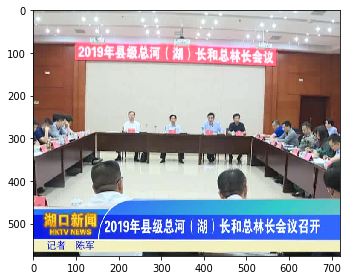

字幕： 湖口新闻 2019年县级总河（湖）长和总林长会议召开 HKTV NEWS 记者陈军
----------------------------------------------------------------------------------------------------



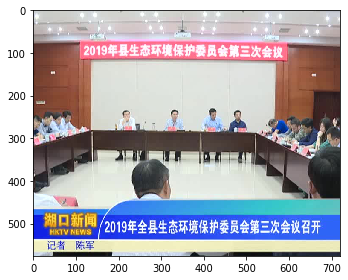

字幕： 湖口新闻 HKTV NEWS 2019年全县生态环境保护委员会第三次会议召开 记者陈军
----------------------------------------------------------------------------------------------------



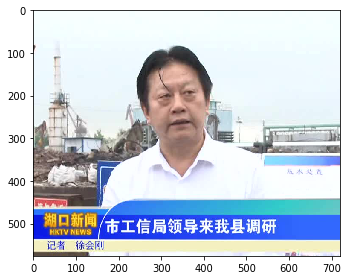

字幕： 湖口新闻 市工信局领导来我县调研 HKTV NEWS 记者徐会刚
----------------------------------------------------------------------------------------------------



In [8]:
def im_to_b64(ar, ext_name='.jpeg'):
    from tempfile import mkstemp
    from base64 import b64encode
    
    _, path = mkstemp(suffix=ext_name)
    try:
        skimage.io.imsave(path, ar)
        with open(path, 'rb') as fp:
            data = fp.read()
    finally:
        os.remove(path)
    return b64encode(data).decode()

def crop_for_subtitme(path):
    im = skimage.io.imread(path)
    height, width, _ = im.shape
    height_crop_fr = math.trunc(height * 0.80)
    height_crop_to = math.trunc(height * 0.02)
    cropped = skimage.util.crop(
        im,
        ((height_crop_fr, height_crop_to), (0, 0), (0, 0))
    )
    return cropped


def ocr(ar):
    url = os.getenv('OCR_API_URL')
    pid = os.getenv('OCR_API_PID')
    key = os.getenv('OCR_API_KEY')
    service = os.getenv('OCR_API_SERVICE')
    salt = os.getenv('OCR_API_SALT')

    def _md5(s):
        m = hashlib.md5()
        m.update(s.encode("utf8"))
        return m.hexdigest()

    image_base64_str = im_to_b64(ar)
    image_short = image_base64_str[0:1024]
    sign = _md5(pid + service + salt + image_short + key)

    data = {
        'pid': pid,
        'service': service,
        'sign': sign,
        'salt': salt,
        'image': image_base64_str,
    }
    headers = {
        'accept': "application/json"
    }
    res = requests.request("POST", url, data=data, headers=headers)
    res = res.json()

    if(res["success"]) == 1:
        result = res['result']
        return result
    else:
        raise RuntimeError("OCR ERROR")

        
print('语音转文本 ...')

_stories = [m for m in stories if m['has_subtitle']]
        
for story in tqdm(_stories):
    if story['has_subtitle']:
        im_path = story['snapshots'][0]
        ar = crop_for_subtitme(im_path)
        story['ocr_result'] = ocr(ar)

print('输出语音转文本的结果和预览图:')
print()

for story in _stories:
    im_path = story['snapshots'][0]
#     display(Image(im_path))
    skimage.io.imshow(im_path)
    plt.pause(1)
    display(Video(story['video_file']))
    subtitles = [group['content'].strip() for group in story['ocr_result']]
    print('字幕：', ' '.join(subtitles))
    print('-' * 100)
    print()

## 语音转本文

使用 *场景识别分类* 一节中，被预测到是演播室的内容，将播报的语音识别为文本

In [143]:
import weblfasr_python3_demo as lfasr


_stories = [m for m in stories if m['in_studio']]

print('语音识别 ...')
sleep(1)

for story in tqdm(_stories):
    asr_req = lfasr.RequestApi(os.getenv("XFYUN_APP_ID"), os.getenv("XFYUN_SECRET_KEY"), story['audio_file'])
    res = asr_req.all_api_request()
    asr_res_data = json.loads(res['data'])
    story['asr-result'] = asr_res_data

print('输出识别结果预览')
print()

for story in _stories:
    display(Video(story['video_file']))
    text = ' '.join(m['onebest'] for m in story['asr-result'])
    print(text)
    print('-' * 100)
    print()

语音识别 ...


/prepare success:{'data': 'a895a5419b36487e8079b67359f7ac21', 'err_no': 0, 'failed': None, 'ok': 0}
/upload success:{'data': None, 'err_no': 0, 'failed': None, 'ok': 0}
upload slice 1 success
/merge success:{'data': None, 'err_no': 0, 'failed': None, 'ok': 0}
/getProgress success:{'data': '{"status":2,"desc":"音频合并完成"}', 'err_no': 0, 'failed': None, 'ok': 0}
The task a895a5419b36487e8079b67359f7ac21 is in processing, task status: {"status":2,"desc":"音频合并完成"}
/getProgress success:{'data': '{"status":9,"desc":"转写结果上传完成"}', 'err_no': 0, 'failed': None, 'ok': 0}
task a895a5419b36487e8079b67359f7ac21 finished
/getResult success:{'data': '[{"bg":"580","ed":"1880","onebest":"观众朋友晚上好！","speaker":"0"},{"bg":"1880","ed":"4330","onebest":"今天是2019年5月16号星期四，","speaker":"0"},{"bg":"4780","ed":"5000","onebest":"今天。","speaker":"0"},{"bg":"5010","ed":"7030","onebest":"湖口新闻的主要内容有","speaker":"0"},{"bg":"7050","ed":"8020","onebest":"2019年。","speaker":"0"},{"bg":"8030","ed":"8730","onebest":"县级总和！","speaker

观众朋友晚上好！ 今天是2019年5月16号星期四， 今天。 湖口新闻的主要内容有 2019年。 县级总和！ 胡长和总领长会议召开。 2019年。 全县生态环境。 保护委员会第三次会议召开， 下面请看详细报道！
----------------------------------------------------------------------------------------------------



5月15号。 县委书记李小平主持召开2019年县级总和。 胡长。 和总磷长会议， 他强调要从树牢四个一事进行两个。 维护的政治高度！ 切实把。 何长志虎涨至零涨至各项工作任务落到实处！ 努力保护好我县河湖森林资源，不断巩固提升绿色生态优势，为争当全市建设长江经济带绿色发展示范区和。 高质量！ 跨越式发展排头兵提供有力保障。县委副书记县长相信开出席会议并讲话，县委副书记张楠，县政协主席杨晓琳，县领导， 有史文查中品张鹏来柯景坤，马海燕，叶子卢伟俊，李水木杨庆周小喜出席会议。
----------------------------------------------------------------------------------------------------



5月15号。 县委书记李小平主持召开2019年全县生态环境。 保护委员会第。 三次会议，县委副书记县长相信开出席会议并讲话，县委副书记张楠，县政协主席杨小林，谢领导使文章中平张虹莱柯景坤马海燕，叶子卢伟俊李水木杨庆周小喜出席会议，会议听取了。 各专业委员会个专项整改小组工作进展情况和问题整改情况的汇报。
----------------------------------------------------------------------------------------------------



5月15号，市工信局党委书记局长陈南桥来我县就传统产业转型升级和沿江小化工企业初侵等工作进行调研。 县委副书记。 县长相信，开县领导柯景坤叶子陪同！
----------------------------------------------------------------------------------------------------



好，以上就是今天新闻的全部内容，感谢收看，再见！
----------------------------------------------------------------------------------------------------

